Packages

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib widget

Calculations

In [2]:
uCi = 3.7 * (10**10) * (10**-6)
year = 3.154*(10**7)
pi = np.pi

activity_0 = 57 * uCi
u_activity_0 = 0.5 * uCi
half_life = 87.7 * year
u_half_life = 0.05 * year
age = 54 * year
u_age = (1/24)*year

activity_expected = activity_0 * np.exp(-np.log(2)*age/half_life)
u_activity_expected = activity_expected * np.sqrt((u_activity_0/activity_0)**2 + (u_age/age)**2 + (u_half_life/half_life)**2)

inch = 2.54 #cm
amu = 1.6605390689*(10**-24)

density = 19.283 #g/cm3
mass_Au = 196.96657 * amu #g

e_0 = 55.26349406 * (10**6) * 10000 #e2 MeV-1 cm-1
k = 1/(4*pi*e_0)
q = 2 #e
Q = 79 #e
E = 5 #MeV
u_E = 0.5


E_squared = E**2
u_E_squared = E_squared*2*u_E/E

z_expected = 0.0002 * inch
u_z_expected = 0.00005 * inch

n_tar = density*z_expected/mass_Au
u_n_tar = density*u_z_expected/mass_Au

A_expected = n_tar*((k*q*Q/(4))**2)/E_squared
u_A_expected = A_expected* np.sqrt((u_n_tar/n_tar)**2 + (u_E_squared/E_squared)**2)

print(A_expected)
print(u_A_expected)
print(activity_expected)
print(activity_expected*A_expected)

3.875738508679358e-05
1.240841759143832e-05
1376327.3379588968
53.34284864275445


Physics Code

In [3]:
xs_min = 1.10 + 0.6 #cm, min distance + thumbscrew thickness
xd_min = 3.66 #cm
z_Au = 0.0005 #cm, or 0.0002 in
d_Au = 0.1 #cm, or 0.040 in
d_Pu = 1.3 #cm
d_det = 0.7 #cm


c = 3 * 10**10 #cm/s
m_alpha = (3.727379 * 10**3)/(c*c) #MeV/c2
E_alpha = 5 #MeV
dE_alpha = 1 #MeV, energy lost in gold

# returns speed of particle in cm/s from kinetic energy E (MeV) and mass (MeV/c2)
def speed(E, m):
    return np.sqrt(2*E/m)

s_alpha = speed(E_alpha, m_alpha)
s2_alpha = speed(E_alpha-dE_alpha, m_alpha)
ds_alpha = s2_alpha-s_alpha

# Alpha partilce object. Contains kinematic variables needed for simulation
class Alpha:
    def __init__(self, t, x, v):
        self.t = t
        self.x = x
        self.v = v

    # returns radial position
    def r(self):
        return np.sqrt(self.x[0]**2 + self.x[1]**2)
    
    # return spherical components of velocity: speed, theta, phi
    def v_sph(self):
        s = np.linalg.norm(self.v)
        theta = np.arccos(self.v[2]/s)
        phi = np.arccos(self.v[0]/(s*np.sin(theta)))
        return np.array([s, theta, phi])

    # given z position and diameter of target (centered at r = 0), returns True and updates position+time if alpha hits target 
    def hit(self, z_targ, d_targ):
        if self.v[2] <= 0:
            return False
        delt = (z_targ-self.x[2])/self.v[2]
        self.t += delt
        self.x = np.add(self.x, delt*self.v)
        return self.r() < d_targ/2
    
    def update(self, t):
        delt = t - self.t
        self.x = np.add(self.x, delt*self.v)
        self.t = t
    
    # given change in speed and scattering angle, updates velocity
    def deflect(self, ds, dtheta, dphi):
        #create basis around self.v
        s = np.linalg.norm(self.v)
        th = self.v_sph()[1]
        v = self.v/s
        d = np.array([1,0,0])
        u = np.cross(v,np.add(v,d))
        u = u/np.linalg.norm(u)
        w = np.cross(v,u)

        # Create basis transformations
        B = np.array([u, w, v]).transpose() #Change of basis matrix v-basis -> standard

        # Create vector in v basis in spherical coordiantes with rotations
        v_B = np.array([np.sin(dtheta) * np.cos(dphi), np.sin(dtheta) * np.sin(dphi), np.cos(dtheta)])

        # transform back to standard basis and update v
        self.v = (s+ds) * np.matmul(B, v_B)
        
        

# Creates alpah particle with random position (uniform in area of disc-shaped source) and direction (uniform in +z direction)
def generate(t):
    r = (d_Pu/2) * np.sqrt(random.random())
    x_phi = (2*pi) * random.random()
    v_theta = np.arccos(random.random())
    v_phi = (2*pi) * random.random()
    x = np.array([r*np.cos(x_phi), r*np.sin(x_phi), 0])
    v = s_alpha * np.array([np.sin(v_theta)*np.cos(v_phi), np.sin(v_theta)*np.sin(v_phi), np.cos(v_theta)])
    return Alpha(t, x, v)

# checks if alphas hit foil, scatters alphas flat in theta, then checks if alphas hit detector
def flat_scatter(a, xs, xd):
    dtheta, itheta = -pi/4, -pi/4
    hit_detector = False
    hit_foil = a.hit(xs_min + xs, d_Au)
    if hit_foil:
        itheta = a.v_sph()[1]
        dtheta =  pi * random.random()
        dphi = (2*pi) * random.random()
        a.deflect(ds_alpha, dtheta, dphi)
        hit_detector = a.hit(xs_min + xs + xd_min + xd, d_det)
    return np.array([hit_foil, hit_detector, dtheta, itheta])

# checks if alphas hit foil, scatters alphas uniformly in solid angle, then checks if alphas hit detector
def spherical_scatter(a, xs, xd):
    dtheta, itheta = -pi/4, -pi/4
    hit_detector = False
    hit_foil = a.hit(xs_min + xs, d_Au)
    if hit_foil:
        itheta = a.v_sph()[1]
        dtheta =  np.arccos(random.uniform(-1,1))
        dphi = (2*pi) * random.random()
        a.deflect(ds_alpha, dtheta, dphi)
        hit_detector = a.hit(xs_min + xs + xd_min + xd, d_det)
    return [hit_foil, hit_detector, dtheta, itheta]

# checks if alphas hit foil, scatters alphas uniformly in solid angle, then checks if alphas hit detector
# instead of choosing random scattering angle, chooses random outgoing angle, and calculates scattering angle after the fact
def fast_spherical_scatter(a, xs, xd):
    dtheta, itheta = -pi/4, -pi/4
    hit_detector = False
    hit_foil = a.hit(xs_min + xs, d_Au)
    if hit_foil:
        itheta = a.v_sph()[1]
        theta =  np.arccos(random.uniform(-1,1))
        phi = (2*pi) * random.random()
        new_v = s2_alpha * np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
        dtheta = np.arccos(np.dot(a.v, new_v)/(s_alpha*s2_alpha))
        a.v = new_v
        hit_detector = a.hit(xs_min + xs + xd_min + xd, d_det)
    return [hit_foil, hit_detector, dtheta, itheta]



# checks if alphas hit foil, scatters alphas with rutherford distribution (given normalization), then checks if alphas hit detectors
def rutherford_scatter(a, xs, xd):
    dtheta, itheta = -pi/4, -pi/4
    hit_detector = False
    hit_foil = a.hit(xs_min + xs, d_Au)
    if hit_foil:
        itheta = a.v_sph()[1]
        # mininum scattering angle (min_theta) determiend by normalization of differential cross section from min_theta to pi, with factor of A
        min_f = -2*10**12 #f(min_theta)
        max_f = -2 #f(pi)
        f = random.uniform(min_f, max_f) #flat distribution in f(theta) = -2csc^2(x/2), integral of (sinx)/(sin^4(x/2))
        dtheta =  2*np.arcsin(np.sqrt(-2/f)) # generates random theta between min_theta and pi, weighted by (sinx)/(sin^4(x/2)) 
        dphi = random.uniform(0, 2*pi)
        a.deflect(ds_alpha, dtheta, dphi)
        hit_detector = a.hit(xs_min + xs + xd_min + xd, d_det)
    return [hit_foil, hit_detector, dtheta, itheta]



Physics Tests

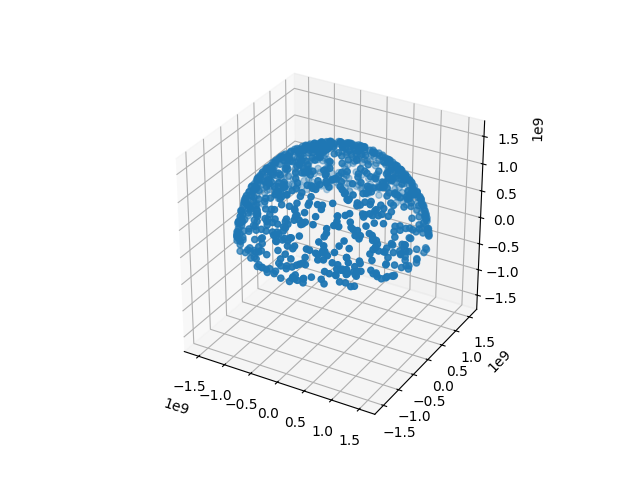

In [4]:
#Test generation of random velocity directions

alphas = [generate(t) for t in range(1000)]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

v = [[a.v[i] for a in alphas] for i in range(3)]

ax.set_box_aspect(aspect = (1,1,1))
ax.scatter(v[0], v[1], v[2])
ax.set_zlim3d(ax.get_xlim3d())

plt.show()

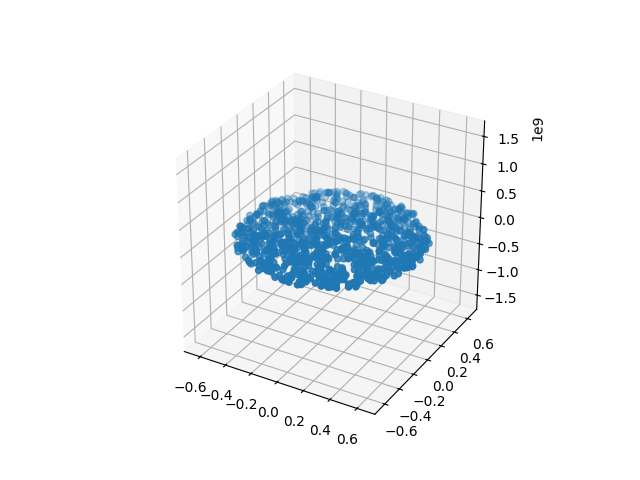

In [5]:
#Test generation of random positions on source
fig = plt.figure()
ax1 = fig.add_subplot(projection='3d')
x = [[a.x[i] for a in alphas] for i in range(3)]

ax1.set_box_aspect(aspect = (1,1,1))
ax1.scatter(x[0], x[1], x[2])
ax1.set_zlim3d(ax.get_xlim3d())

plt.show()

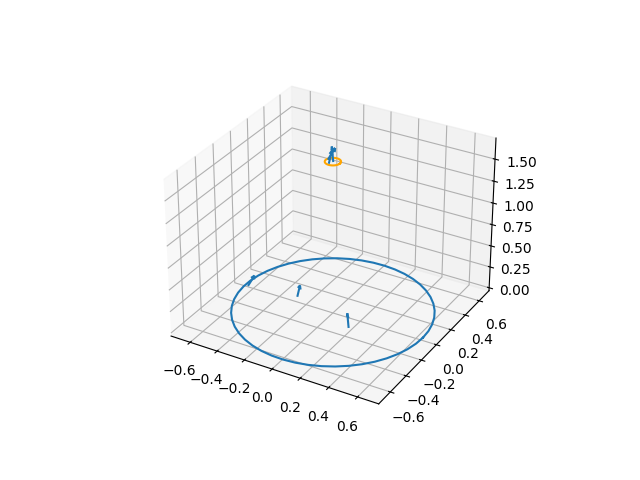

In [6]:
# Test hitting foil 
alphas = [generate(t) for t in range(10000)]

fig = plt.figure()
ax1 = fig.add_subplot(projection='3d')
#ax1.quiver(x[0], x[1], x[2], v[0], v[1], v[2], length=0.00000000005)

v = [[a.v[i] for a in alphas] for i in range(3)]
x = [[a.x[i] for a in alphas] for i in range(3)]

x0 = [[], [], []]
v0 = [[], [], []]

xi = [[], [], []]
vi = [[], [], []]

for a in alphas:
    for i in range(3):
        x0[i].append(a.x[i])
        v0[i].append((a.v[i]))
    if a.hit(xs_min, d_Au):
    
        for i in range(3):
            xi[i].append(a.x[i])
            vi[i].append((a.v[i]))
    else:
        for i in range(3):
            x0[i].pop()
            v0[i].pop()
    

t = np.linspace(0, 2*pi)
cx = np.cos(t)
cy = np.sin(t)

ax1.plot(cx*d_Pu/2, cy*d_Pu/2,0)
ax1.plot(cx*d_Au/2, cy*d_Au/2,xs_min, color='orange')

ax1.quiver(x0[0], x0[1], x0[2], v0[0], v0[1], v0[2], length=0.0000000001)
ax1.quiver(xi[0], xi[1], xi[2], vi[0], vi[1], vi[2], length=0.0000000001)

plt.show()



v [0.27309572 0.90725437 0.31985659]
v_B [0.1545085  0.26761657 0.95105652]
[[ 0.         -0.96198686  0.27309572]
 [ 0.3324958   0.25755787  0.90725437]
 [-0.94310474  0.09080318  0.31985659]]
v1 [0.00228585 0.98315036 0.18278443]


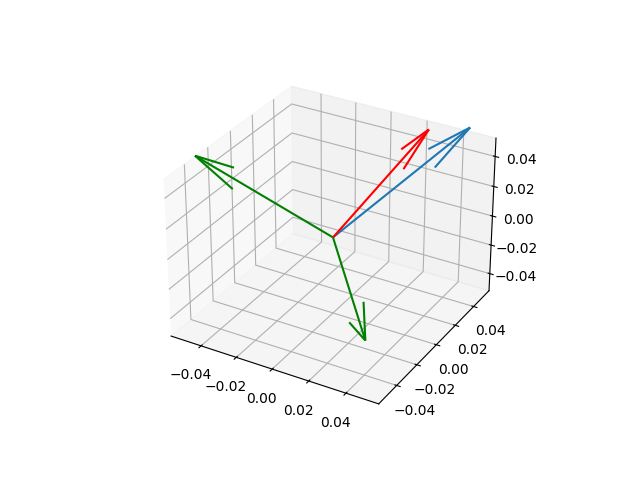

In [14]:
# Test deflect method

a = generate(0)

fig = plt.figure()
ax1 = fig.add_subplot(projection='3d')

v0 = a.v
v= v0

dtheta = pi/10
dphi = pi/3
ds = 0


s = np.linalg.norm(v0)
theta = np.arccos(v0[2]/s)



# Create vector perpendicular to v
v = v0/s
u = np.cross(v,np.add(v, np.array([1,0,0])))
u = u/np.linalg.norm(u)
w = np.cross(v,u)

# Create basis transformations
B = np.array([u, w, v]).transpose() #Change of basis matrix v-basis -> standard
print("v " + str(v))

# Create vector in v basis in spherical coordiantes with rotations
v_B = np.array([np.sin(dtheta) * np.cos(dphi), np.sin(dtheta) * np.sin(dphi), np.cos(dtheta)])
print("v_B " + str(v_B))

# transform back to standard basis
v1 = np.matmul(B, v_B)
print(B)
print("v1 " + str(v1))

# adjust magnitude
#s += ds
#v1 = s * new_v/np.linalg.norm(new_v)

ax1.quiver(0,0,0, v[0], v[1], v[2], length=.1)
ax1.quiver(0,0,0, u[0], u[1], u[2], length=.1, color = 'green')
ax1.quiver(0,0,0, w[0], w[1], w[2], length=.1, color = 'green')
#ax1.quiver(0,0,0, v_B[0], v_B[1], v_B[2], length=0.00000000001, color = 'orange')
#ax1.quiver(0,0,0, 0, 0, 1, length=0.00000000001, color = 'orange')
ax1.quiver(0,0,0, v1[0], v1[1], v1[2], length=.1, color='red')

plt.show()

[[], [], []]


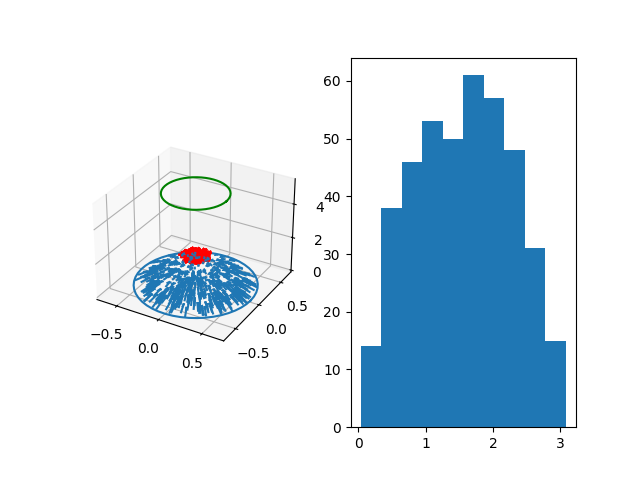

In [8]:
# Test hitting foil and uniform scattering
alphas = [generate(t) for t in range(1000000)]

fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
#ax1.quiver(x[0], x[1], x[2], v[0], v[1], v[2], length=0.00000000005)

v = [[a.v[i] for a in alphas] for i in range(3)]
x = [[a.x[i] for a in alphas] for i in range(3)]

x0 = [[], [], []]
v0 = [[], [], []]

xi = [[], [], []]
vi = [[], [], []]

xs = [[], [], []]
vs = [[], [], []]

xd = [[], [], []]
vd = [[], [], []]

dtheta = []
itheta = []
stheta = []
iphi = []
dphi = []

for a in alphas:
    for i in range(3):
        x0[i].append(a.x[i])
        v0[i].append((a.v[i]))
    a_copy = Alpha(a.t, a.x, a.v)
    if a_copy.hit(xs_min, d_Au):
        itheta.append(a_copy.v_sph()[1])
        iphi.append(a_copy.v_sph()[2])
        for i in range(3):
            xi[i].append(a_copy.x[i])
            vi[i].append(a_copy.v[i])
            xs[i].append(a_copy.x[i])
    else:
        for i in range(3):
            x0[i].pop()
            v0[i].pop()
    result = spherical_scatter(a, 0, 0)  
    if result[0]: 
        dtheta.append(result[2])
        stheta.append(a.v_sph()[1])

        for i in range(3):       
            vs[i].append(a.v[i])
            if result[1]:
                xd[i].append(a.x[i])
                vd[i].append(a.v[i])
    

t = np.linspace(0, 2*pi)
cx = np.cos(t)
cy = np.sin(t)

ax1.plot(cx*d_Pu/2, cy*d_Pu/2,0)
ax1.plot(cx*d_Au/2, cy*d_Au/2,xs_min, color='orange')
ax1.plot(cx*d_det/2, cy*d_det/2,xs_min+xd_min, color='green')


print(xd)

ax1.quiver(x0[0], x0[1], x0[2], v0[0], v0[1], v0[2], length=0.0000000002)
ax1.quiver(xi[0], xi[1], xi[2], vi[0], vi[1], vi[2], length=0.00000000007)
ax1.quiver(xs[0], xs[1], xs[2], vs[0], vs[1], vs[2], length=0.0000000001, color = 'red')
if len(xd[0]) != 0:
    ax1.quiver(xd[0], xd[1], xd[2], vd[0], vd[1], vd[2], length=0.0000000002, color = 'red')

ax2 =  fig.add_subplot(122)
ax2.hist(dtheta)

plt.show()

NameError: name 'spherical_scatter2' is not defined

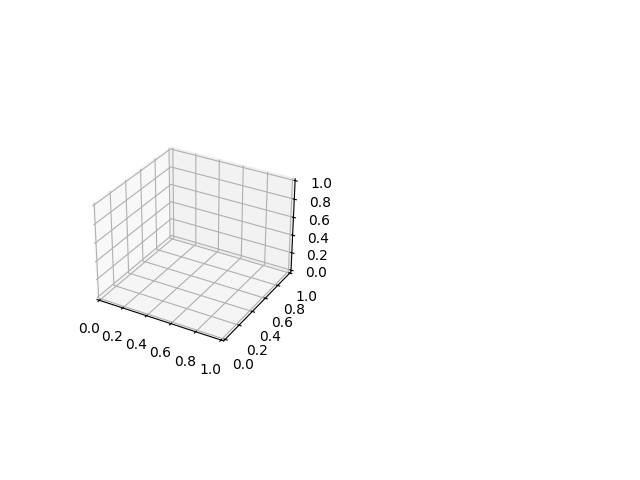

In [9]:
# Test hitting foil and uniform scattering2
alphas = [generate(t) for t in range(100000)]

fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
#ax1.quiver(x[0], x[1], x[2], v[0], v[1], v[2], length=0.00000000005)

v = [[a.v[i] for a in alphas] for i in range(3)]
x = [[a.x[i] for a in alphas] for i in range(3)]

x0 = [[], [], []]
v0 = [[], [], []]

xi = [[], [], []]
vi = [[], [], []]

xs = [[], [], []]
vs = [[], [], []]

xd = [[], [], []]
vd = [[], [], []]

dtheta = []
itheta = []
stheta = []
iphi = []
dphi = []

for a in alphas:
    for i in range(3):
        x0[i].append(a.x[i])
        v0[i].append((a.v[i]))
    a_copy = Alpha(a.t, a.x, a.v)
    if a_copy.hit(xs_min, d_Au):
        itheta.append(a_copy.v_sph()[1])
        iphi.append(a_copy.v_sph()[2])
        for i in range(3):
            xi[i].append(a_copy.x[i])
            vi[i].append(a_copy.v[i])
            xs[i].append(a_copy.x[i])
    else:
        for i in range(3):
            x0[i].pop()
            v0[i].pop()
    result = spherical_scatter2(a, 0, 0)  
    if result[0]: 
        dtheta.append(result[2])
        stheta.append(a.v_sph()[1])
        for i in range(3):       
            vs[i].append(a.v[i])
            if result[1]:
                xd[i].append(a.x[i])
                vd[i].append(a.v[i])

t = np.linspace(0, 2*pi)
cx = np.cos(t)
cy = np.sin(t)

ax1.plot(cx*d_Pu/2, cy*d_Pu/2,0)
ax1.plot(cx*d_Au/2, cy*d_Au/2,xs_min, color='orange')
ax1.plot(cx*d_det/2, cy*d_det/2,xs_min+xd_min, color='green')


print(xd)

ax1.quiver(x0[0], x0[1], x0[2], v0[0], v0[1], v0[2], length=0.0000000002)
ax1.quiver(xi[0], xi[1], xi[2], vi[0], vi[1], vi[2], length=0.00000000007)
ax1.quiver(xs[0], xs[1], xs[2], vs[0], vs[1], vs[2], length=0.0000000001, color = 'red')
if len(xd[0]) != 0:
    ax1.quiver(xd[0], xd[1], xd[2], vd[0], vd[1], vd[2], length=0.0000000002, color = 'red')

ax2 =  fig.add_subplot(122)
ax2.hist(dtheta)

plt.show()

[[np.float64(0.16332585582682452), np.float64(-0.2471871647641833), np.float64(-0.22138595258266225), np.float64(0.10707888858449194), np.float64(0.3385259339103738), np.float64(-0.21902158385244047), np.float64(-0.1847306196044441), np.float64(-0.04112878965110647), np.float64(0.16299226798967664)], [np.float64(-0.20613270341219597), np.float64(-0.04656502924975835), np.float64(-0.01401753953035762), np.float64(0.036632353983995815), np.float64(0.030153419500212317), np.float64(-0.13489106698138392), np.float64(0.27971881842259194), np.float64(0.13457873511179397), np.float64(-0.19028136683047364)], [np.float64(5.36), np.float64(5.359999999999999), np.float64(5.36), np.float64(5.36), np.float64(5.36), np.float64(5.36), np.float64(5.36), np.float64(5.36), np.float64(5.360000000000001)]]


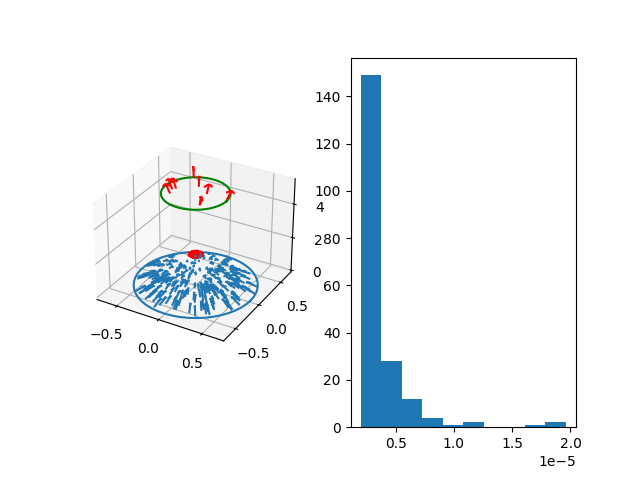

In [15]:
# Test hitting foil and rutherford scattering
alphas = [generate(t) for t in range(500000)]

fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
#ax1.quiver(x[0], x[1], x[2], v[0], v[1], v[2], length=0.00000000005)

v = [[a.v[i] for a in alphas] for i in range(3)]
x = [[a.x[i] for a in alphas] for i in range(3)]

x0 = [[], [], []]
v0 = [[], [], []]

xi = [[], [], []]
vi = [[], [], []]

xs = [[], [], []]
vs = [[], [], []]

xd = [[], [], []]
vd = [[], [], []]

dtheta = []
itheta = []
stheta = []
iphi = []
dphi = []

for a in alphas:
    for i in range(3):
        x0[i].append(a.x[i])
        v0[i].append((a.v[i]))
    a_copy = Alpha(a.t, a.x, a.v)
    if a_copy.hit(xs_min, d_Au):
        itheta.append(a_copy.v_sph()[1])
        iphi.append(a_copy.v_sph()[2])
        for i in range(3):
            xi[i].append(a_copy.x[i])
            vi[i].append(a_copy.v[i])
            xs[i].append(a_copy.x[i])
    else:
        for i in range(3):
            x0[i].pop()
            v0[i].pop()
    result = rutherford_scatter(a, 0, 0)  
    if result[0]: 
        dtheta.append(result[2])
        stheta.append(a.v_sph()[1])

        for i in range(3):       
            vs[i].append(a.v[i])
            if result[1]:
                xd[i].append(a.x[i])
                vd[i].append(a.v[i])

t = np.linspace(0, 2*pi)
cx = np.cos(t)
cy = np.sin(t)

ax1.plot(cx*d_Pu/2, cy*d_Pu/2,0)
ax1.plot(cx*d_Au/2, cy*d_Au/2,xs_min, color='orange')
ax1.plot(cx*d_det/2, cy*d_det/2,xs_min+xd_min, color='green')


print(xd)

ax1.quiver(x0[0], x0[1], x0[2], v0[0], v0[1], v0[2], length=0.0000000002)
ax1.quiver(xi[0], xi[1], xi[2], vi[0], vi[1], vi[2], length=0.00000000007)
ax1.quiver(xs[0], xs[1], xs[2], vs[0], vs[1], vs[2], length=0.0000000001, color = 'red')
if len(xd[0]) != 0:
    ax1.quiver(xd[0], xd[1], xd[2], vd[0], vd[1], vd[2], length=0.0000000004, color = 'red')

ax2 =  fig.add_subplot(122)
ax2.hist(dtheta)

plt.show()

In [ ]:
# Test hitting foil and modified rutherford scattering
alphas = [generate(t) for t in range(500000)]

fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
#ax1.quiver(x[0], x[1], x[2], v[0], v[1], v[2], length=0.00000000005)

v = [[a.v[i] for a in alphas] for i in range(3)]
x = [[a.x[i] for a in alphas] for i in range(3)]

x0 = [[], [], []]
v0 = [[], [], []]

xi = [[], [], []]
vi = [[], [], []]

xs = [[], [], []]
vs = [[], [], []]

xd = [[], [], []]
vd = [[], [], []]

dtheta = []
itheta = []
stheta = []
iphi = []
dphi = []

for a in alphas:
    for i in range(3):
        x0[i].append(a.x[i])
        v0[i].append((a.v[i]))
    a_copy = Alpha(a.t, a.x, a.v)
    if a_copy.hit(xs_min, d_Au):
        itheta.append(a_copy.v_sph()[1])
        iphi.append(a_copy.v_sph()[2])
        for i in range(3):
            xi[i].append(a_copy.x[i])
            vi[i].append(a_copy.v[i])
            xs[i].append(a_copy.x[i])
    else:
        for i in range(3):
            x0[i].pop()
            v0[i].pop()
    result = rutherford_scatter2(a, 0, 0)  
    if result[0]: 
        dtheta.append(result[2])
        stheta.append(a.v_sph()[1])

        for i in range(3):       
            vs[i].append(a.v[i])
            if result[1]:
                xd[i].append(a.x[i])
                vd[i].append(a.v[i])

t = np.linspace(0, 2*pi)
cx = np.cos(t)
cy = np.sin(t)

ax1.plot(cx*d_Pu/2, cy*d_Pu/2,0)
ax1.plot(cx*d_Au/2, cy*d_Au/2,xs_min, color='orange')
ax1.plot(cx*d_det/2, cy*d_det/2,xs_min+xd_min, color='green')


print(xd)

ax1.quiver(x0[0], x0[1], x0[2], v0[0], v0[1], v0[2], length=0.0000000002)
ax1.quiver(xi[0], xi[1], xi[2], vi[0], vi[1], vi[2], length=0.00000000007)
ax1.quiver(xs[0], xs[1], xs[2], vs[0], vs[1], vs[2], length=0.0000000001, color = 'red')
if len(xd[0]) != 0:
    ax1.quiver(xd[0], xd[1], xd[2], vd[0], vd[1], vd[2], length=0.0000000004, color = 'red')

ax2 =  fig.add_subplot(122)
ax2.hist(dtheta)

plt.show()

In [ ]:
# Test hitting foil and modified rutherford scattering
alphas = [generate(t) for t in range(500000)]

fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
#ax1.quiver(x[0], x[1], x[2], v[0], v[1], v[2], length=0.00000000005)

v = [[a.v[i] for a in alphas] for i in range(3)]
x = [[a.x[i] for a in alphas] for i in range(3)]

x0 = [[], [], []]
v0 = [[], [], []]

xi = [[], [], []]
vi = [[], [], []]

xs = [[], [], []]
vs = [[], [], []]

xd = [[], [], []]
vd = [[], [], []]

dtheta = []
itheta = []
stheta = []
iphi = []
dphi = []

for a in alphas:
    for i in range(3):
        x0[i].append(a.x[i])
        v0[i].append((a.v[i]))
    a_copy = Alpha(a.t, a.x, a.v)
    if a_copy.hit(xs_min, d_Au):
        itheta.append(a_copy.v_sph()[1])
        iphi.append(a_copy.v_sph()[2])
        for i in range(3):
            xi[i].append(a_copy.x[i])
            vi[i].append(a_copy.v[i])
            xs[i].append(a_copy.x[i])
    else:
        for i in range(3):
            x0[i].pop()
            v0[i].pop()
    result = rutherford_scatter3(a, 0, 0)  
    if result[0]: 
        dtheta.append(result[2])
        stheta.append(a.v_sph()[1])

        for i in range(3):       
            vs[i].append(a.v[i])
            if result[1]:
                xd[i].append(a.x[i])
                vd[i].append(a.v[i])

t = np.linspace(0, 2*pi)
cx = np.cos(t)
cy = np.sin(t)

ax1.plot(cx*d_Pu/2, cy*d_Pu/2,0)
ax1.plot(cx*d_Au/2, cy*d_Au/2,xs_min, color='orange')
ax1.plot(cx*d_det/2, cy*d_det/2,xs_min+xd_min, color='green')


print(xd)

ax1.quiver(x0[0], x0[1], x0[2], v0[0], v0[1], v0[2], length=0.0000000002)
ax1.quiver(xi[0], xi[1], xi[2], vi[0], vi[1], vi[2], length=0.00000000007)
ax1.quiver(xs[0], xs[1], xs[2], vs[0], vs[1], vs[2], length=0.0000000001, color = 'red')
if len(xd[0]) != 0:
    ax1.quiver(xd[0], xd[1], xd[2], vd[0], vd[1], vd[2], length=0.0000000004, color = 'red')

ax2 =  fig.add_subplot(122)
ax2.hist(dtheta)

plt.show()

Simulations

In [ ]:
# simulates generation, scattering, and detection of N alpha particles given xs, xd
# models generation of alphas every 1 second (actiivty = 1 Hz)
# models flat scattering, then weights number of scattered particles by rutherford * spherical distribution 

def simulate_flat(x, N):
    u_N_detected = 0
    results = np.array([flat_scatter(generate(t),x[1],x[0]) for t in range(N)])
    #    results = np.array(list(map(lambda t: flat_scatter(generate(t),x[1],x[0]), range(N))))

    hit_foil = results[:,0].astype(bool)
    scatters = results[hit_foil]

    hit_detector, dtheta = scatters[:,1].astype(bool), scatters[:,2]
    N_incident = len(scatters)
    N_scattered = sum(np.sin(dtheta)/((np.sin(dtheta/2))**4))/N_incident
    N_hit = sum(hit_detector)
    N_detected = sum(hit_detector * np.sin(dtheta)/((np.sin(dtheta/2))**4))/N_incident
    if N_hit > 0:
        u_N_detected = 0.5*N_detected/N_hit
    return N_detected, u_N_detected, scatters

#modified
def simulate_flat_cos(x, N):
    u_N_detected = 0
    results = np.array([flat_scatter(generate(t),x[1],x[0]) for t in range(N)])
    
    hit_foil = results[:,0].astype(bool)
    scatters = results[hit_foil]
   
    hit_detector, dtheta, itheta = scatters[:,1].astype(bool), scatters[:,2], scatters[:,3]

    N_incident = len(scatters)
    N_scattered = sum(np.sin(dtheta)/(np.cos(itheta)*(np.sin(dtheta/2))**4))/N_incident
    N_hit = sum(hit_detector)
    N_detected = sum(hit_detector * np.sin(dtheta)/(np.cos(itheta)*(np.sin(dtheta/2))**4))/N_incident
    if N_hit > 0:
        u_N_detected = 0.5*N_detected/N_hit
    print(N_incident)
    print(N_scattered)
    print(N_hit)
    print(N_detected)
    return N_detected, u_N_detected, scatters


# simulates generation, scattering, and detection of N alpha particles given xs, xd
# models generation of alphas every 1 second (actiivty = 1 Hz)
# models spherical scattering, then weights number of scattered particles by rutherford  distribution 
def simulate_spherical(x, N):
    u_N_detected = 0
    results = np.array([spherical_scatter(generate(t),x[1],x[0]) for t in range(N)])
    
    hit_foil = results[:,0].astype(bool)
    scatters = results[hit_foil]
   
    hit_detector, dtheta = scatters[:,1].astype(bool), scatters[:,2]

    N_incident = len(scatters)
    N_scattered = sum(1/((np.sin(dtheta/2))**4))/N_incident
    N_hit = sum(hit_detector)
    N_detected = sum(hit_detector/((np.sin(dtheta/2))**4))/N_incident
    if N_hit > 0:
        u_N_detected = 0.5*N_detected/N_hit
    return N_detected, u_N_detected, scatters

def simulate_spherical_fast(x, N):
    u_N_detected = 0
    results = np.array([fast_spherical_scatter(generate(t),x[1],x[0]) for t in range(N)])
    
    hit_foil = results[:,0].astype(bool)
    scatters = results[hit_foil]
   
    hit_detector, dtheta = scatters[:,1].astype(bool), scatters[:,2]

    N_incident = len(scatters)
    N_scattered = sum(1/((np.sin(dtheta/2))**4))/N_incident
    N_hit = sum(hit_detector)
    N_detected = sum(hit_detector/((np.sin(dtheta/2))**4))/N_incident
    if N_hit > 0:
        u_N_detected = 0.5*N_detected/N_hit
    return N_detected, u_N_detected, scatters

# models spherical scattering, then weights number of scattered particles by modified rutherford  distribution  
def simulate_spherical_cos(x, N):
    u_N_detected=0
    results = np.array([spherical_scatter(generate(t),x[1],x[0]) for t in range(N)])
    
    hit_foil = results[:,0].astype(bool)
    scatters = results[hit_foil]
   
    hit_detector, dtheta, itheta = scatters[:,1].astype(bool), scatters[:,2], scatters[:,3]

    N_incident = len(scatters)
    N_scattered = sum(1/(np.cos(itheta)*(np.sin(dtheta/2))**4))/N_incident
    N_hit = sum(hit_detector)
    N_detected = sum(hit_detector/(np.cos(itheta)*(np.sin(dtheta/2))**4))/N_incident
    if N_hit > 0:
        u_N_detected = 0.5*N_detected/N_hit
    return N_detected, u_N_detected, scatters

def simulate_spherical_fast_cos(x, N):
    u_N_detected = 0
    results = np.array([fast_spherical_scatter(generate(t),x[1],x[0]) for t in range(N)])
    
    hit_foil = results[:,0].astype(bool)
    scatters = results[hit_foil]
   
    hit_detector, dtheta, itheta = scatters[:,1].astype(bool), scatters[:,2], scatters[:,3]

    N_incident = len(scatters)
    N_scattered = sum(1/(np.cos(itheta)*(np.sin(dtheta/2))**4))/N_incident
    N_hit = sum(hit_detector)
    N_detected = sum(hit_detector/(np.cos(itheta)*(np.sin(dtheta/2))**4))/N_incident
    if N_hit > 0:
        u_N_detected = 0.5*N_detected/N_hit
    return N_detected, u_N_detected, scatters

def simulate_rutherford(x, N):
    results = np.array([rutherford_scatter(generate(t),x[1],x[0]) for t in range(N)])
    hit_foil = results[:,0].astype(bool)
    scatters = results[hit_foil]

    N_scattered = len(scatters)
    N_detected = sum(scatters[:,1])
    u_N_detected = 0.5*N_detected

    return N_detected, u_N_detected


Simulation Tests

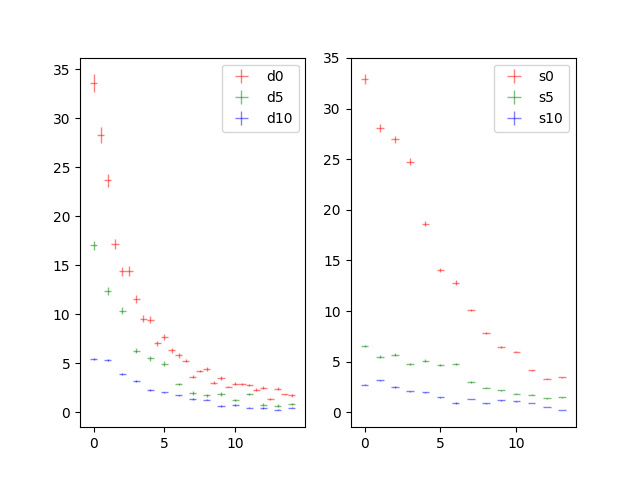

In [ ]:
from data_helper import read_csv
import montecarlo


def reproduce_plots(data):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    d0_data = data[0:, 0:29]
    d5_data = data[0:, 29:44]
    d10_data = data[0:, 44:59]
    s0_data = data[0:,59:73]
    s5_data = data[0:,73:87]
    s10_data = data[0:, 87:]

    ax1.errorbar(d0_data[0, :], d0_data[2, :], xerr=d0_data[3,:], yerr=d0_data[5,:], fmt='none', lw = 1, color='red', alpha=0.5, label='d0')
    ax1.errorbar(d5_data[0, :], d5_data[2, :], xerr=d5_data[3,:], yerr=d5_data[5,:], fmt='none', lw = 1, color='green', alpha=0.5, label='d5')
    ax1.errorbar(d10_data[0, :], d10_data[2, :], xerr=d10_data[3,:], yerr=d10_data[5,:], fmt='none', lw = 1, color='blue', alpha=0.5, label='d10')

    ax2.errorbar(s0_data[1, :], s0_data[2, :], xerr=s0_data[4,:], yerr=s0_data[5,:], fmt='none', lw = 1, color='red', alpha=0.5, label='s0')
    ax2.errorbar(s5_data[1, :], s5_data[2, :], xerr=s5_data[4,:], yerr=s5_data[5,:], fmt='none', lw = 1, color='green', alpha=0.5, label='s5')
    ax2.errorbar(s10_data[1, :], s10_data[2, :], xerr=s10_data[4,:], yerr=s10_data[5,:], fmt='none', lw = 1, color='blue', alpha=0.5, label='s10')

    ax1.legend()
    ax2.legend()
    plt.show()


# Plot data again 
csv_data = read_csv('data.csv')
reproduce_plots(csv_data)




In [ ]:
N = 10000000
print(A_expected*simulate_spherical((0,0),N)[0]/N)

In [ ]:
N=1000000
print(A_expected*activity_expected*simulate_flat((0,0),N)[0]/N)

[1. 2. 2. 4. 0. 1. 0. 0. 0. 2. 0. 1. 2. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 4. 3. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 2. 1. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 4. 5. 3. 3. 4. 4. 4. 6. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 2. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0.]


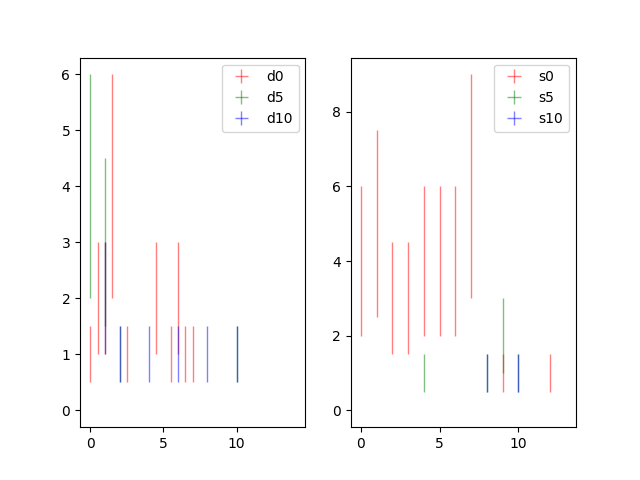

In [ ]:
l = len(csv_data[0])
rutherford_data = np.array([csv_data[0], csv_data[1], np.zeros(l), np.zeros(l), np.zeros(l), np.zeros(l)])
xx = np.transpose(rutherford_data[0:2])
N = 100000
results = np.transpose(np.array([simulate_rutherford(x,N) for x in xx]))
rutherford_data[2] = results[0]
rutherford_data[5] = results[1]
print(rutherford_data[2])

reproduce_plots(rutherford_data)

In [ ]:
print(rutherford_data[4])

Data Analysis Funcitons

In [ ]:
from data_helper import read_csv

Data Analysis Tests

Measurment Optimization